<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Check-your-sample-table-(i.e.-metadata-file)" data-toc-modified-id="Check-your-sample-table-(i.e.-metadata-file)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Check your sample table (i.e. metadata file)</a></span></li><li><span><a href="#Check-your-TRN" data-toc-modified-id="Check-your-TRN-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check your TRN</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load the data</a></span></li></ul></li><li><span><a href="#Regulatory-iModulons" data-toc-modified-id="Regulatory-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regulatory iModulons</a></span></li><li><span><a href="#Functional-iModulons" data-toc-modified-id="Functional-iModulons-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functional iModulons</a></span><ul class="toc-item"><li><span><a href="#GO-Enrichments" data-toc-modified-id="GO-Enrichments-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>GO Enrichments</a></span></li><li><span><a href="#KEGG-Enrichments" data-toc-modified-id="KEGG-Enrichments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>KEGG Enrichments</a></span></li></ul></li></ul></div>

# Setup
This IPython notebook will walk through the steps of characterizing iModulons through semi-automated tools. You will need:
* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table (See the gene table notebook)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
import sys
sys.path.append('..')

In [2]:
from pymodulon.core import IcaData
from os import path
import pandas as pd
import re

In [3]:
# Enter the location of your data here
data_dir = '../pymodulon/test/modulome_data/'

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [4]:
df_metadata = pd.read_csv(path.join(data_dir,'sample_table.csv'),index_col=0)
df_metadata[['project','condition']].head()

,project,condition
SRX3467357,FadR,wt_p
SRX3467358,FadR,wt_p
SRX3467359,FadR,ko_p
SRX3467360,FadR,ko_p
SRX3565164,GDGT,75_2.4_log


In [5]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [6]:
df_trn = pd.read_csv(path.join(data_dir,'TRN.tsv'),sep='\t')
df_trn.head()

,regulator,gene_id,regulator_id,gene_name,old_locus_tag,gene_issue,other_id,direction,evidence,PMID,Additional Notes
0,BarR,SACI_RS10330,SACI_RS10330,barR,Saci_2136,NaN,3472865,NaN,qRT-PCR,24646198,BarR TF (Lrp/AsnC family transcriptional regul...
1,BarR,SACI_RS10335,SACI_RS10330,NaN,Saci_2137,NaN,3472866,+,qRT-PCR,24646198,NaN
2,BarR,SACI_RS00130,SACI_RS10330,NaN,Saci_0028,NaN,3472576,NaN,"ChIP-Seq, qRT-PCR",27502941,NaN
3,BarR,SACI_RS00275,SACI_RS10330,meaB,Saci_0061,NaN,3472976,NaN,"ChIP-Seq, qRT-PCR",27502941,NaN
4,BarR,SACI_RS03305,SACI_RS10330,infB,Saci_0695,NaN,3472541,NaN,"ChIP-Seq, qRT-PCR",27502941,NaN


The `regulator` and `gene_id` must be filled in for each row

In [7]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object

In [8]:
ica_data = IcaData(M = path.join(data_dir,'M.csv'),
                   A = path.join(data_dir,'A.csv'),
                   X = path.join(data_dir,'X.csv'),
                   gene_table = path.join(data_dir,'gene_table.csv'),
                   sample_table = path.join(data_dir,'sample_table.csv'),
                   trn = path.join(data_dir,'TRN.tsv'))

# Regulatory iModulons
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [9]:
ica_data.compute_trn_enrichment()

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,4,ArnR;ArnR1,8.720300e-21,1.046436e-19,0.727273,1.000,0.842105,8.0,11.0,8.0,1.0
1,4,ArnA;ArnB,4.140730e-16,2.484438e-15,0.500000,0.875,0.636364,7.0,14.0,8.0,1.0
2,26,FadR,3.721716e-12,4.466059e-11,0.315789,0.750,0.444444,6.0,19.0,8.0,1.0


You can also search for AND/OR combinations of regulators using the `max_regs` argument. Here, we see that iModulon #4 may be regulated by the both ArnR;ArnR1 and ArnA;ArnB.

In [10]:
ica_data.compute_trn_enrichment(max_regs=2)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,4,ArnR;ArnR1,8.720300e-21,3.662526e-19,0.727273,1.000,0.842105,8.0,11.0,8.0,1.0
1,4,ArnR;ArnR1+ArnA;ArnB,1.209743e-19,2.540461e-18,1.000000,0.875,0.933333,7.0,7.0,8.0,2.0
2,4,ArnA;ArnB,4.140730e-16,5.797022e-15,0.500000,0.875,0.636364,7.0,14.0,8.0,1.0
3,26,FadR,3.721716e-12,1.563121e-10,0.315789,0.750,0.444444,6.0,19.0,8.0,1.0


Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table. For iModulon #4, it will automatically save `ArnR;ArnR1` as the enrichment, but we want to save `ArnR;ArnR1+ArnA;ArnB`. We can update our enrichments accordingly, using `compute_regulon_enrichment`:

In [11]:
ica_data.compute_trn_enrichment(max_regs=2,save=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,4,ArnR;ArnR1,8.720300e-21,3.662526e-19,0.727273,1.000,0.842105,8.0,11.0,8.0,1.0
1,4,ArnR;ArnR1+ArnA;ArnB,1.209743e-19,2.540461e-18,1.000000,0.875,0.933333,7.0,7.0,8.0,2.0
2,4,ArnA;ArnB,4.140730e-16,5.797022e-15,0.500000,0.875,0.636364,7.0,14.0,8.0,1.0
3,26,FadR,3.721716e-12,1.563121e-10,0.315789,0.750,0.444444,6.0,19.0,8.0,1.0


In [12]:
ica_data.imodulon_table.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ArnR;ArnR1,8.720300e-21,3.662526e-19,0.727273,1.0,0.842105,8.0,11.0,8.0,1.0


In [13]:
ica_data.compute_regulon_enrichment(4,'ArnR;ArnR1+ArnA;ArnB',save=True)

pvalue           1.209743e-19
precision        1.000000e+00
recall           8.750000e-01
f1score          9.333333e-01
TP               7.000000e+00
regulon_size     7.000000e+00
imodulon_size    8.000000e+00
n_regs           2.000000e+00
Name: ArnR;ArnR1+ArnA;ArnB, dtype: float64

In [14]:
ica_data.imodulon_table.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ArnR;ArnR1+ArnA;ArnB,1.209743e-19,3.662526e-19,1.0,0.875,0.933333,7.0,7.0,8.0,2.0


# Functional iModulons

## GO Enrichments

In [15]:
# Coming soon!

## KEGG Enrichments
This will be moved into a function within pymodulon, and will include a save function

In [16]:
from Bio.KEGG import REST
from io import StringIO
from tqdm.notebook import tqdm

Create a dataframe mapping locus tags to KEGG orthologies

In [17]:
df_kegg_map = ica_data.gene_table['KEGG_ko'].dropna().str.split(';',expand=True).reset_index().melt(id_vars='locus_tag')
df_kegg_map = df_kegg_map.rename({'value':'kegg_orth','locus_tag':'gene_id'},axis=1)
df_kegg_map = df_kegg_map[['gene_id','kegg_orth']]
df_kegg_map = df_kegg_map[df_kegg_map.kegg_orth.notnull()]
df_kegg_map.head()

,gene_id,kegg_orth
0,SACI_RS00005,ko:K10725
1,SACI_RS00040,ko:K01916
2,SACI_RS00060,ko:K01515
3,SACI_RS00070,ko:K01151
4,SACI_RS00085,ko:K01560


Link orthologies to pathways using KEGG

In [18]:
def kegg_link_batch(df_annotation,database):
    chunk_size = 100
    list2struct = []
    for i in tqdm(range(len(df_annotation)//chunk_size)):
        kegg_str = '+'.join(df_annotation.kegg_orth[i*chunk_size:i*chunk_size+chunk_size])
        response = REST.kegg_link(database,kegg_str)
        stream = StringIO(response.read())
        tmp_df = pd.read_csv(stream,sep='\t',header=None,names=['kegg_orth',database])
        # Remove path:ko terms, only keep path:map terms
        tmp_df = tmp_df[~tmp_df[database].str.startswith('path:ko')]
        list2struct.append(tmp_df)
    df_kegg_link = pd.concat(list2struct)
    
    DF_pathways = pd.merge(df_annotation,df_kegg_link,on='kegg_orth')[['gene_id',database]]
    return DF_pathways

In [19]:
kegg_pathways = kegg_link_batch(df_kegg_map,'pathway')
kegg_modules = kegg_link_batch(df_kegg_map,'module')

In [20]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'pathway')
for idx,key in tqdm(DF_pathway_enrich.pathway.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    name = re.search('\t(.*)\n',text).group(1)
    DF_pathway_enrich.loc[idx,'pathway_name'] = name
    
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'module')
for idx,key in tqdm(DF_module_enrich.module.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    name = re.search('\t(.*)\n',text).group(1)
    DF_module_enrich.loc[idx,'module_name'] = name

In [21]:
DF_pathway_enrich

,pathway,TP,f1score,imodulon_size,imodulon,precision,pvalue,qvalue,recall,target_set_size,pathway_name
0,path:map00920,4.0,0.444444,10.0,1,0.500000,1.262214e-08,0.000003,0.400000,8.0,Sulfur metabolism
1,path:map01120,5.0,0.064103,10.0,1,0.034247,1.888403e-04,0.019262,0.500000,300.0,Microbial metabolism in diverse environments
2,path:map00072,2.0,0.266667,5.0,7,0.200000,1.696115e-04,0.011964,0.400000,82.0,Synthesis and degradation of ketone bodies
3,path:map00310,2.0,0.222222,5.0,7,0.153846,2.932234e-04,0.011964,0.400000,87.0,Lysine degradation
4,path:map00362,2.0,0.235294,5.0,7,0.166667,2.483291e-04,0.011964,0.400000,84.0,Benzoate degradation
5,path:map00380,2.0,0.222222,5.0,7,0.153846,2.932234e-04,0.011964,0.400000,87.0,Tryptophan metabolism
6,path:map04975,2.0,0.285714,5.0,7,0.222222,1.358078e-04,0.011964,0.400000,81.0,Fat digestion and absorption
7,path:map00900,2.0,0.190476,5.0,7,0.125000,4.499310e-04,0.013112,0.400000,89.0,Terpenoid backbone biosynthesis
8,path:map02020,2.0,0.200000,5.0,7,0.133333,3.940342e-04,0.013112,0.400000,93.0,Two-component system
9,path:map00071,2.0,0.153846,5.0,7,0.095238,7.839410e-04,0.019990,0.400000,106.0,Fatty acid degradation


In [22]:
DF_module_enrich

,module,TP,f1score,imodulon_size,imodulon,precision,pvalue,qvalue,recall,target_set_size,module_name
0,md:M00176,2.0,0.333333,10.0,1,1.000000,1.708000e-05,2.374120e-03,0.200000,2.0,"Assimilatory sulfate reduction, sulfate => H2S"
1,md:M00088,2.0,0.266667,5.0,7,0.200000,1.696115e-04,1.018951e-02,0.400000,82.0,"Ketone body biosynthesis, acetyl-CoA => acetoa..."
2,md:M00095,2.0,0.222222,5.0,7,0.153846,2.932234e-04,1.018951e-02,0.400000,85.0,"C5 isoprenoid biosynthesis, mevalonate pathway"
3,md:M00373,2.0,0.266667,5.0,7,0.200000,1.696115e-04,1.018951e-02,0.400000,82.0,Ethylmalonyl pathway
4,md:M00849,2.0,0.222222,5.0,7,0.153846,2.932234e-04,1.018951e-02,0.400000,85.0,"C5 isoprenoid biosynthesis, mevalonate pathway..."
5,md:M00375,2.0,0.129032,5.0,7,0.076923,1.207938e-03,3.358069e-02,0.400000,107.0,Hydroxypropionate-hydroxybutylate cycle
6,md:M00374,2.0,0.117647,5.0,7,0.068966,1.505029e-03,3.486650e-02,0.400000,109.0,Dicarboxylate-hydroxybutyrate cycle
7,md:M00125,2.0,0.444444,7.0,21,1.000000,7.970668e-06,1.107923e-03,0.285714,2.0,"Riboflavin biosynthesis, GTP => riboflavin/FMN..."
8,md:M00088,2.0,0.307692,3.0,28,0.200000,5.112088e-05,4.101987e-03,0.666667,82.0,"Ketone body biosynthesis, acetyl-CoA => acetoa..."
9,md:M00095,2.0,0.250000,3.0,28,0.153846,8.853209e-05,4.101987e-03,0.666667,85.0,"C5 isoprenoid biosynthesis, mevalonate pathway"


# ICA Comparison

### Comparsion within the same organism

`compare_ica` is a function specifically built to compare the components between different ICA runs. The function will return a Digraph plot which shows connections between ICA components of different runs, as well as Dictionary List of the one-to-one connections. 

The function requires a minimum of two inputs if running a comparison beween two ICA runs for the same organism:
* S1: Pandas Dataframe of M matrix 1
* S2: Pandas Dataframe of M Matrix 2

`compare_ica` can be found in **pymodulon.compare**

In [23]:
from pymodulon.compare import *

100%|██████████| 92/92 [00:00<00:00, 104.54it/s]


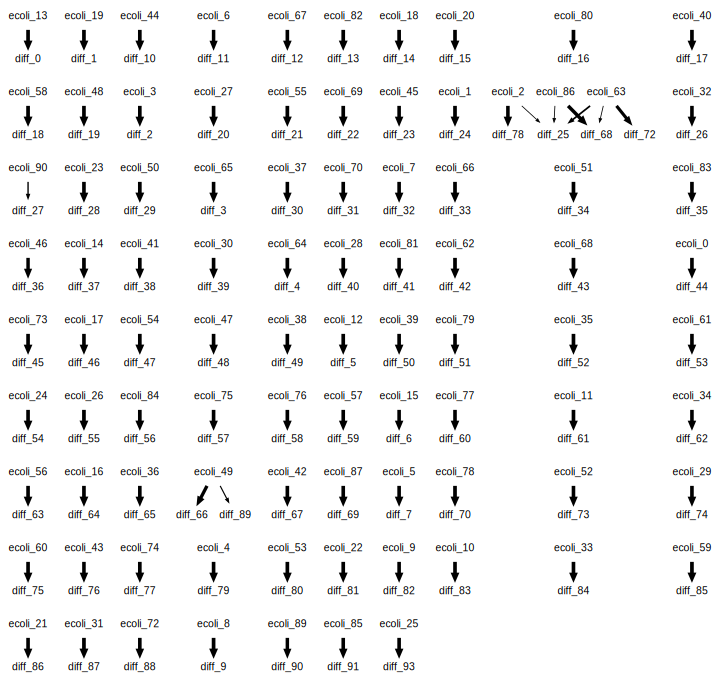

In [24]:
# Load extra data and relabel components

ica_run = pd.read_csv("../pymodulon/test/data/ecoli_S.csv",index_col=0)
col_copy=list(ica_run.columns)
for i in range(0,len(col_copy)):
    col_copy[i] = "ecoli_"+col_copy[i]
ica_run.columns=col_copy

ica_run_diff = pd.read_csv("../pymodulon/test/data/ecoli_S_mod.csv",index_col=0)
col_copy = list(ica_run_diff.columns)
for i in range(0,len(col_copy)):
    col_copy[i] = "diff_"+col_copy[i]
ica_run_diff.columns=col_copy

# Run comapare_ica

dots,links = compare_ica(ica_run,ica_run_diff)
dots

For comparisons of ICA components between the same organism, you find that components will be very closely correlated with each other. The thickness of the arrow will indicate the correlation coefficient between components, and arrows can also indicate if components split/merge. 

You can also see components which do not have any correlations by using the keyword `show_all`. The default for `show_all` is **False**

100%|██████████| 92/92 [00:00<00:00, 103.92it/s]


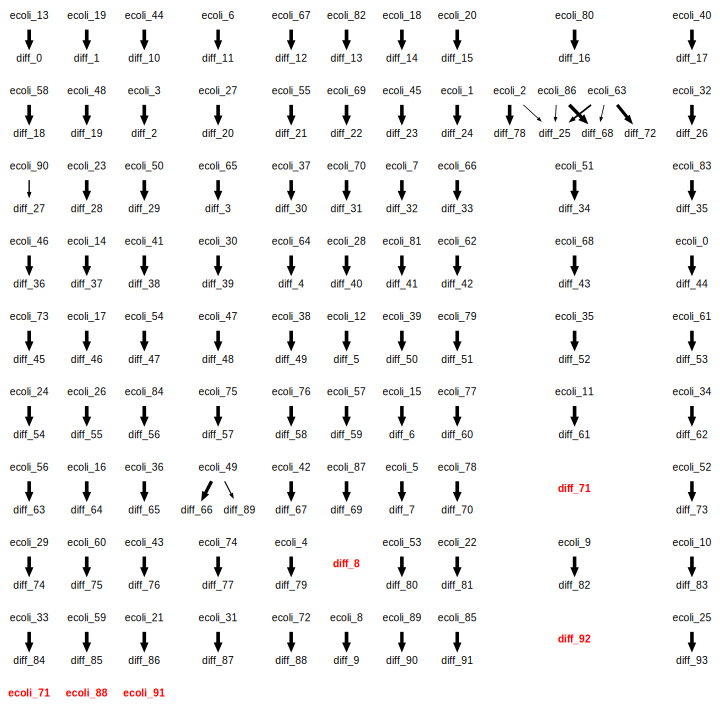

In [25]:
dots,links = compare_ica(ica_run,ica_run_diff,show_all = True)
dots

Additionally, you can adjust the metric type and cutoff values for correlations by utilizing the `metric` and `cutoff` parameters. The default for `metric` is "*pearson*", but can be changed to "*spearman*" by inputting the string. 

`cutoff` takes a float value between 0 and 1 and will change `compare_ica` to only show correlations greater than the cutoff value.

100%|██████████| 92/92 [00:08<00:00, 10.30it/s]


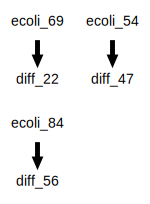

In [26]:
dots,links = compare_ica(ica_run,ica_run_diff,metric="spearman",cutoff=.98)
dots

### Comparison across organisms

`compare_ica` can also be used to compare ICA components between different organisms. To do so, you will need to provide an addition input, which is a string path to a Bidirectional Best Hit between your two organisms of interest.

A Github repository containing many BBH CSV's can be found at the following link: https://github.com/SBRG/modulome_compare_data

The CSV files will be found at "../modulome_compare_data/bbh_csv/". You can also provide a path to your own BBH file, as long as it contains the columns **"gene"** and **"target"**

../pymodulon/compare.py:191: UserWarning: Please ensure that the order of S1 and S2 match the order of the BBH CSV file
  warnings.warn("Please ensure that the order of S1 and S2 match the "
100%|██████████| 92/92 [00:00<00:00, 316.11it/s]


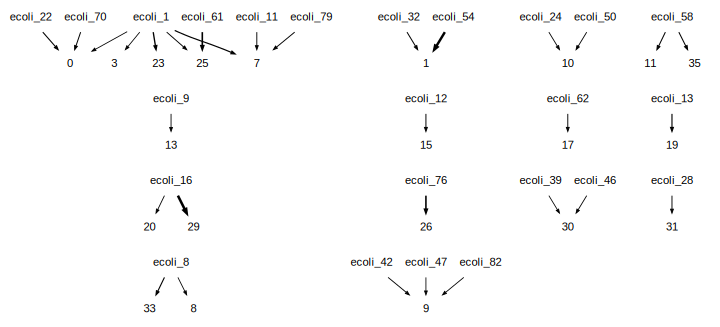

In [27]:
dots,links = compare_ica(ica_run,ica_data.M,
                         ortho_file = "/home/sbrg/Desktop/modulome_compare_data/bbh_csv/" \
                         "eColi_full_protein_vs_sAcidocaldarius_full_protein_parsed.csv")
dots

It is important that the order of the organism matches the order of the bbh file. Specifically, the organism for the "M1" file must be the organism that fills the "gene" column in the bbh csv. Otherwise, errors will occur.

In [28]:
dots,links = compare_ica(ica_data.M,ica_run,
                         ortho_file = "/home/sbrg/Desktop/modulome_compare_data/bbh_csv/" \
                         "eColi_full_protein_vs_sAcidocaldarius_full_protein_parsed.csv")
dots

../pymodulon/compare.py:191: UserWarning: Please ensure that the order of S1 and S2 match the order of the BBH CSV file
  warnings.warn("Please ensure that the order of S1 and S2 match the "


KeyError: 'No common genes'